In [1]:
import json

In [2]:
import requests
import geopandas as gpd
import pandas as pd

In [3]:
from bs4 import BeautifulSoup
from shapely.geometry import Point
from tqdm.notebook import tqdm

## Open GIS Data

In [4]:
file_path = "data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
states_df = gpd.read_file(file_path)

## Get Population Data

In [5]:
state_populations = pd.read_excel(
    "data/NST-EST2023-POP.xlsx", sheet_name=None, engine="openpyxl"
)

In [6]:
state_populations_df = state_populations["NST-EST2023-POP"][
    [
        "table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)",
        "Unnamed: 5",
    ]
]
state_populations_df = state_populations_df.rename(
    columns={
        "table with row headers in column A and column headers in rows 3 through 4. (leading dots indicate sub-parts)": "NAME",
        "Unnamed: 5": "POPULATION",
    }
)
state_populations_df["NAME"] = state_populations_df["NAME"].str[1:]

In [7]:
states_with_population_df = states_df.merge(state_populations_df, on="NAME", how="left")
states_with_population_df = states_with_population_df[
    ["STUSPS", "POPULATION", "geometry"]
]

In [8]:
states_with_population_df = states_with_population_df.dropna()

## Get Distillery Data

In [9]:
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"
}
r = requests.get(
    "https://www.distillerytrail.com/distillery-directory-map/", headers=headers
)

In [10]:
soup = BeautifulSoup(r.text, "html.parser")

In [11]:
divs = soup.find_all("div", {"class": "drts-location-entities-map-container"})

In [12]:
div = divs[0]
script = div.find_all("script")[0]

In [13]:
almost_data = script.text.split("setMarkers")[1]

In [14]:
formatted_data_in_str = "}".join(almost_data[2:].split("}")[:-2]) + "}"
formatted_data_in_str = f"[{formatted_data_in_str}]"

In [15]:
distillery_data_list = json.loads(formatted_data_in_str)

Parsing Distilleries:   0%|          | 0/2109 [00:00<?, ?it/s]

{'index': 0, 'entity_id': 17238, 'content': '<div class="drts-bs-card drts-bs-border-0 drts-bs-bg-dark drts-bs-text-white drts-map-marker-content">\n\n<div class="drts-bs-card-img-overlay drts-bs-p-2">\n<div class="drts-bs-card-title"><a href="https://www.distillerytrail.com/directory-distillery/listing/delaware-distilling-company/" class="drts-bs-text-white drts-entity-permalink drts-entity-17238" title="Delaware Distilling Company (Closed)" data-type="post" data-content-type="directory__listing" data-content-name="distillery_dir_ltg">Delaware Distilling Company (Closed)</a></div>\n<address class="drts-map-marker-address drts-bs-card-text">18693 Coastal Hwy, Rehoboth Beach, Delaware 19971, United States</address>\n</div></div>', 'lat': 38.720945, 'lng': -75.076014, 'icon': None}

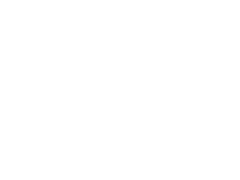

In [17]:
coord_list = []
state_counts = {}
distilleries = []
for distillery in tqdm(distillery_data_list, desc="Parsing Distilleries"):
    point = Point(distillery["lng"], distillery["lat"])
    try:
        state_code = states_df[states_df.intersects(point)]["STUSPS"].iloc[0]
        distilleries.append(point)
    except IndexError:
        print(distillery)
        continue

    if state_code not in state_counts:
        state_counts[state_code] = 1
    else:
        state_counts[state_code] += 1

In [18]:
distilleries_per_state_series = pd.Series(state_counts, name="distilleries")
distilleries_per_state_df = distilleries_per_state_series.reset_index()
distilleries_per_state_df = distilleries_per_state_df.rename(
    columns={"index": "STUSPS"}
)

## Merge Data

In [19]:
distilleries_per_state_df = states_with_population_df.merge(
    distilleries_per_state_df, on="STUSPS", how="left"
)

In [20]:
distilleries_per_state_df["per_100k"] = distilleries_per_state_df["distilleries"] / (
    distilleries_per_state_df["POPULATION"] / 100000
)
distilleries_per_state_df["per_500k"] = distilleries_per_state_df["distilleries"] / (
    distilleries_per_state_df["POPULATION"] / 500_000
)
distilleries_per_state_df["per_1m"] = distilleries_per_state_df["distilleries"] / (
    distilleries_per_state_df["POPULATION"] / 1_000_000
)

In [21]:
distilleries_per_state_df["per_1m"] = distilleries_per_state_df["distilleries"] / (
    distilleries_per_state_df["POPULATION"] / 1000000
)

In [22]:
distilleries_per_state_df = distilleries_per_state_df.to_crs(2163)

In [23]:
distilleries_per_state_df.to_file("data/distilleries.gpkg")

/mnt/c/Users/Winston/Documents/GitHub/VineMapper/.venv/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: CRS EPSG:2163 is deprecated. Its non-deprecated replacement EPSG:9311 will be used instead. To use the original CRS, set the OSR_USE_NON_DEPRECATED configuration option to NO.
  ogr_write(


In [27]:
distilleries_df = gpd.GeoDataFrame(geometry=distilleries, crs="4326")
distilleries_df = distilleries_df.to_crs(2163)
distilleries_df.to_file("data/all_distilleries.gpkg")